<font size='5'>Задания в системе выдаются по очереди: после сдачи ответа по очередному заданию студенту выдаётся следующее без возможности вернуться к предыдущему. Для того чтобы завершить сдачу экзамена, необходимо ввести ответы на все вопросы. Также будем считать, что задания в системе бывают только тестового типа: в каждой задаче студенту нужно выбрать один из нескольких вариантов ответа.<font>

In [15]:
import pandas as pd
import seaborn as sns
sns.set(rc={'figure.figsize':(11.7,8.27)})

In [16]:
exam = pd.read_csv('exam.csv')

In [17]:
user_answer = pd.read_csv('user_answer.csv')
user_answer['time'] = pd.to_datetime(user_answer['time'], format='%Y-%m-%d %H-%M-%S')

In [18]:
user_answer.sort_values(by='user_id')

,exam_id,user_id,task_ind,answer,verdict,time
1920,1,1,1,0,WA,2023-12-15 16:08:36
1925,1,1,6,3,WA,2023-12-15 16:16:07
1926,1,1,7,3,WA,2023-12-15 16:16:12
1927,1,1,8,2,WA,2023-12-15 16:16:58
1928,1,1,9,0,WA,2023-12-15 16:17:04
...,...,...,...,...,...,...
3664,2,529,1,3,WA,2023-12-20 10:07:25
3812,2,530,1,1,WA,2023-12-20 10:42:50
3813,2,530,2,0,OK,2023-12-20 10:42:52
3814,2,530,3,0,WA,2023-12-20 10:43:47


In [19]:
user_answer = user_answer.sort_values(by='time')
user_answer['time_diff'] = user_answer['time'].diff().apply(lambda x: x.total_seconds())

<font size='5'>Первой метрикой подозрительности будет количество задач, ответы на которые были даны в течение 20 сек после такого же ответа кого-либо другого на то же задание. Именно в силу того, что нельзя возвращаться к предыдущим заданиям, скорее всего, если кто-то у кого-то списывает, то узнать ответ он может спустя маленький промежуток времени. Будем считать,что это списывание происходит в течении 20 сек.<font>

In [20]:
uagrouped = user_answer.groupby(['exam_id','task_ind'])
df_grouped = pd.concat([df.reset_index(drop=True) for _, df in uagrouped]).fillna(0)

In [21]:
df_grouped

,exam_id,user_id,task_ind,answer,verdict,time,time_diff
0,1,102,1,2,WA,2023-12-15 10:00:08,0.0
1,1,90,1,1,OK,2023-12-15 10:00:10,2.0
2,1,91,1,0,WA,2023-12-15 10:00:49,27.0
3,1,89,1,1,OK,2023-12-15 10:00:52,3.0
4,1,70,1,0,WA,2023-12-15 10:00:56,2.0
...,...,...,...,...,...,...,...
525,2,398,4,3,WA,2023-12-20 14:02:13,1.0
526,2,30,4,3,WA,2023-12-20 14:42:06,30.0
527,2,231,4,3,WA,2023-12-20 14:55:15,23.0
528,2,515,4,1,WA,2023-12-20 15:14:52,15.0


In [22]:
suspicios_1 = {u_id:0 for u_id in user_answer['user_id'].unique()}
for wind in df_grouped.rolling(window=5,min_periods=1):
    user = wind.iloc[-1]
    diff = 0
    for i in range(len(wind)-1):
        x = wind.iloc[i]
        diff += x['time_diff']
        if x['task_ind'] == user['task_ind'] and x['answer'] == user['answer'] and diff <= 20:
            suspicios_1[user['user_id']] += 1
            suspicios_1[x['user_id']] += 1

In [23]:
lst = pd.DataFrame(list(suspicios_1.items()),columns=['user_id','susp_1'])

<font size='5'>Второй метрикой будет количество совпадений ответов ученика с другими, а третьей - количество совпадений ТОЛЬКО НЕВЕРНЫХ ответов ученика с другими.<font>

In [24]:
u_ans = pd.read_csv('user_answer.csv').drop(columns=['time'])

In [25]:
u_ans = u_ans.merge(u_ans, on=['exam_id','task_ind'])

In [26]:
u_ans = u_ans.copy()
u_ans['is_eq'] = (u_ans['answer_x'] == u_ans['answer_y'])
u_ans['is_eq_WA'] = u_ans['is_eq'] & (u_ans['verdict_x'] == 'WA')

In [27]:
lst = lst.merge(u_ans.groupby('user_id_x').agg({'is_eq':'sum'}).reset_index().rename(columns={'is_eq':'susp_2'}), left_on='user_id',right_on='user_id_x')
lst = lst.drop(columns=['user_id_x'])

In [28]:
lst = lst.merge(u_ans.groupby('user_id_x').agg({'is_eq_WA':'sum'}).reset_index().rename(columns={'is_eq_WA':'susp_3'}), left_on='user_id',right_on='user_id_x')

In [29]:
lst = lst.drop(columns=['user_id_x'])

<font size='4'>Для каждой метрики определим "аномалии" - тех людей, которые имеют слишком большое значение метрики подозрительности. Сделаем это с помощью "коробок с усами".<font>

<Axes: xlabel='variable', ylabel='value'>

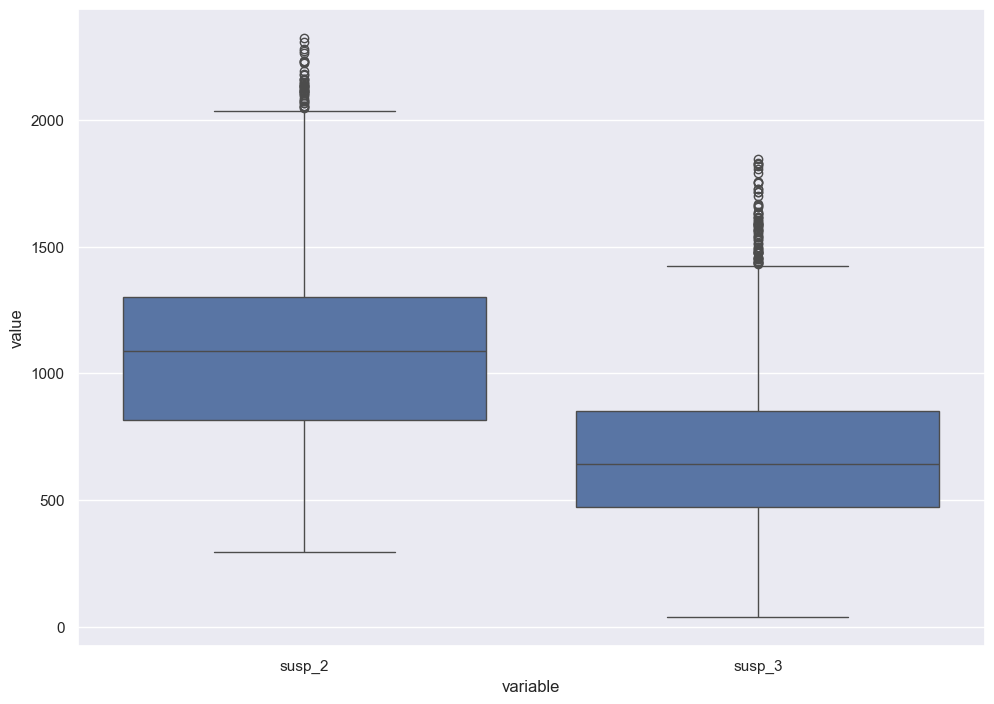

In [30]:
df_long = pd.melt(lst, value_vars=['susp_2', 'susp_3'])
sns.boxplot(data=df_long, x='variable', y='value')

<Axes: ylabel='susp_1'>

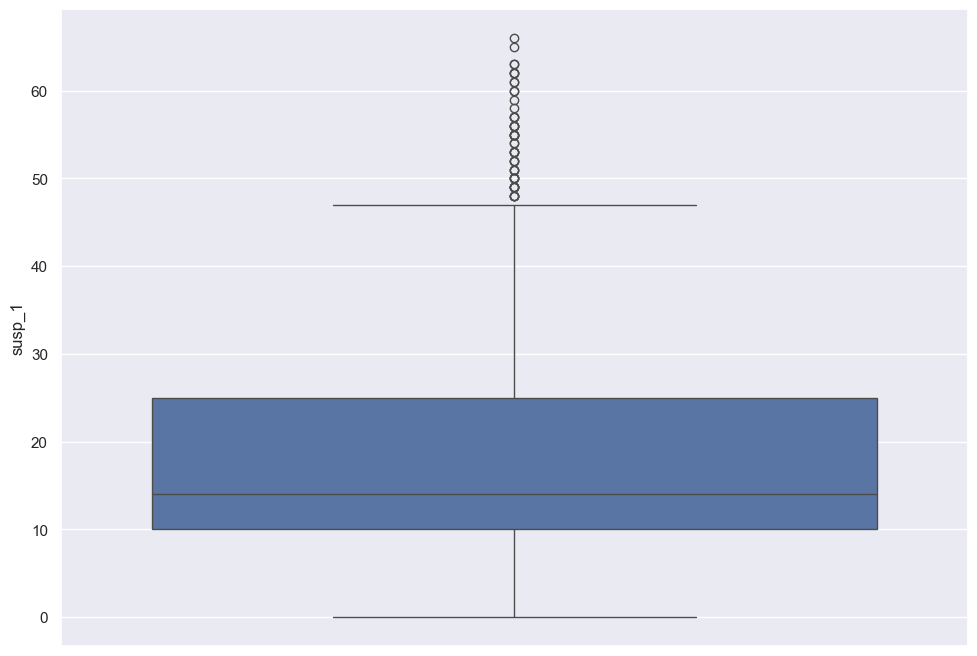

In [35]:
sns.boxplot(lst['susp_1'])

<font size='5'>Осталось вычислить user_id этих аномалий для каждой метрики и взять пересечение подозрительных ребят (тех, кто являются аномалиями для всех метрик подозрительности)<font>.

In [39]:
Q1_2, Q3_2 = lst['susp_2'].quantile([0.25, 0.75])
IQR_2 = Q3_2 - Q1_2
outliers_2 = lst[lst['susp_2'] > Q3_2 + 1.5*IQR_2]
susp_2 = pd.DataFrame()
susp_2['user_id'] = pd.Series(outliers_2['user_id'].unique())

In [40]:
Q1_3, Q3_3 = lst['susp_3'].quantile([0.25, 0.75])
IQR_3 = Q3_3 - Q1_3
outliers_3 = lst[lst['susp_3'] > Q3_3 + 1.5*IQR_3]
susp_3 = pd.DataFrame()
susp_3['user_id'] = pd.Series(outliers_3['user_id'].unique())

In [41]:
Q1_1, Q3_1 = lst['susp_1'].quantile([0.25, 0.75])
IQR_1 = Q3_1 - Q1_1
outliers_1 = lst[lst['susp_1'] > Q3_1 + 1.5*IQR_1]
susp_1 = pd.DataFrame()
susp_1['user_id'] = pd.Series(outliers_1['user_id'].unique())

In [42]:
ans = susp_1.merge(susp_2, on='user_id',how='inner').merge(susp_3, on='user_id',how='inner')

In [49]:
tuple(ans['user_id'])

(64,
 101,
 25,
 30,
 69,
 107,
 47,
 3,
 103,
 119,
 111,
 126,
 10,
 93,
 122,
 31,
 38,
 104,
 34,
 81,
 92,
 83,
 56,
 120,
 13)

In [50]:
len(ans)

25

<font size='5'>Вывод: проверить 25 ребят из таблицы ans<font>